In [1]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from lensless.plot import plot_image
import numpy as np
import pandas as pd
from pprint import pprint

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs, figsize=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [11]:
%load_ext autoreload
%autoreload 2

## Preparing CelebA dataset

Unfortunately using PyTorch utilities for download CelebA crashes due to the huge file size. So we recommend:
1. Downloading the dataset from the original website: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
2. Unzipping the files.
3. Creating a folder called `celeba` which has the files listed in the [source code](https://github.com/pytorch/vision/blob/e0467c64e337c0d1140a9f9a70a413b7268231f4/torchvision/datasets/celeba.py#L47) of PyTorch's CelebA wrapper. Note that you can find `"img_align_celeba.zip"` inside the `Img` folder.
4. You can use the `torchvision.datasets.CelebA` wrapper by providing the folder where `celeb` lies (as shown below).

# Exploring dataset

In [2]:
# preparin
ds = datasets.CelebA(
    root="../data",
    split="all",
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0,), (1,))]
    ),
)

In [3]:
# print dataset info
print(f"Number of files : {len(ds)}")
iden = np.unique(ds.identity.numpy())
print(f"Unique identities : {len(iden)}")
print(f"Attributes : {ds.attr_names}")

Number of files : 202599
Unique identities : 10177
Attributes : ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


In [4]:
interesting_metadata = ["Male", "Smiling", "Eyeglasses", "Young"]
metadata_idx = []
for i, _val in enumerate(ds.attr_names):
    if _val in interesting_metadata:
        metadata_idx.append(i)
print(metadata_idx)

[15, 20, 31, 39]


# plot an image

Shape : torch.Size([3, 218, 178])
Maximum value : 1.0
Minimum value : 0.0

METADATA
{'Eyeglasses': 0, 'Male': 0, 'Smiling': 1, 'Young': 1}


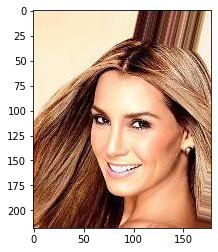

In [5]:
# plot an image
idx = 0
gamma = 1
normalize_plot = True

img, labels = ds[idx]
print(f"Shape : {img.shape}")
print(f"Maximum value : {img.max()}")
print(f"Minimum value : {img.min()}")
input_image_cpu = np.transpose(img.cpu(), (1, 2, 0))
plot_image(input_image_cpu, gamma=gamma, normalize=normalize_plot)

print("\nMETADATA")
metadata_dict = {}
for i in metadata_idx:
    metadata_dict[ds.attr_names[i]] = labels[i].item()
pprint(metadata_dict)

# metadata distribution
https://pytorch.org/vision/main/_modules/torchvision/datasets/celeba.html#CelebA

In [6]:
attr = pd.DataFrame(ds.attr[:, metadata_idx], columns = interesting_metadata)
attr["identity"] = ds.identity.numpy()
print(attr.shape)
attr.head()

(202599, 5)


,Male,Smiling,Eyeglasses,Young,identity
0,0,0,1,1,2880
1,0,0,1,1,2937
2,0,1,0,1,8692
3,0,0,0,1,5805
4,0,0,0,1,9295


In [7]:
attr["Smiling"].value_counts()

0    118165
1     84434
Name: Smiling, dtype: int64

In [8]:
attr["Male"].value_counts()

0    189406
1     13193
Name: Male, dtype: int64

In [9]:
attr["identity"].value_counts()[:10]
## NOT ENOUGH IMAGES PER IDENTITY?

3227    35
2820    35
3782    35
3745    34
3699    34
9152    32
8968    32
9256    32
4887    31
6568    31
Name: identity, dtype: int64

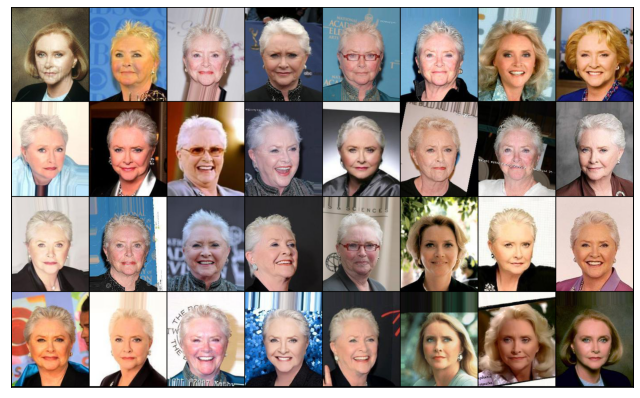

In [10]:
# plot image of one identity
_id = 9152
n_image = 50

image_idx = attr.loc[attr["identity"] == _id].index
imgs = []
for i in range(n_image):
    if i < len(image_idx):
        imgs.append(ds[image_idx[i]][0])
grid = make_grid(imgs)
show(grid, figsize=(18, 7))

# augment with PSF

In [1]:
from lenslessclass.datasets import CelebAPropagated
import numpy as np
from lensless.plot import plot_image


psf_fp = "../psfs/tape.png"
crop_psf = False
mask2sensor = 4e-3

psf_fp = "../psfs/lens.png"
crop_psf = 100
mask2sensor = 0.00753

output_dim = (480, 640)
noise_type = "speckle"
snr = 40


down_psf = 1
object_height = 0.18
grayscale = True
single_psf = False
scene2mask = 40e-2

device = "cpu"

pixel_size = np.array([1.55e-6, 1.55e-6])
sensor_shape = np.array([3040, 4056])
sensor_size = pixel_size * sensor_shape
attribute = "Male"

ds_aug = CelebAPropagated(
    psf_fp=psf_fp,
    attribute=attribute,
    downsample_psf=down_psf,
    output_dim=output_dim,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    sensor_size=sensor_size,
    object_height=object_height,
    device=device,
    crop_psf=crop_psf,
    grayscale=grayscale,
    vflip=False,
    split="test",
    single_psf=single_psf,
    root="../data",
    noise_type=noise_type,
    snr=snr
)

(100, 100, 1)


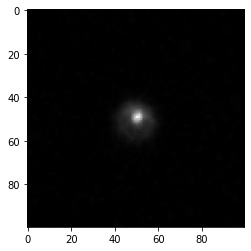

In [2]:
# plot PSF
psf_data = ds_aug.psf.cpu().clone().numpy().transpose(1, 2, 0)
print(psf_data.shape)
ax = plot_image(psf_data, gamma=2.2);

In [3]:
len(ds_aug)

19962

(480, 640, 1)
tensor(1)


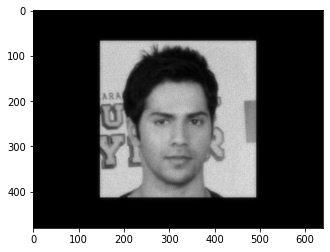

In [9]:
# plot simulated
dataset_idx = 5
img, label = ds_aug[dataset_idx]
# if grayscale:
#     img_data = img.cpu().clone().numpy().squeeze()
# else:
img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
print(label)
plot_image(img_data);

In [39]:
from lensless.util import resize
import cv2

psf = resize(psf_data, 3 / 19, interpolation=cv2.INTER_CUBIC).astype(np.float32)[:, :, np.newaxis]
print(psf.shape)

img_data_norm = img_data / img_data.max()

(15, 15, 1)


Setup time : 0.26001739501953125 s
Processing time : 41.52565836906433 s


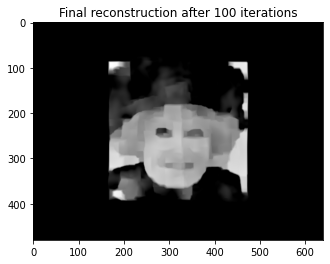

In [7]:
import time
from lensless import ADMM

n_iter = 100
disp = n_iter + 1
gamma = 2.2

start_time = time.time()
recon = ADMM(psf)
recon.set_data(img_data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

In [66]:
ds = datasets.CelebA(
    root="../data",
    split="test",
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0,), (1,))]
    ),
)


(218, 178, 3)


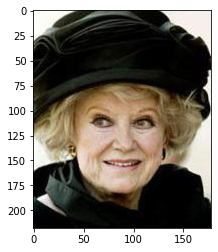

In [67]:
img, label = ds[dataset_idx]
# if grayscale:
#     img_data = img.cpu().clone().numpy().squeeze()
# else:
img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
plot_image(img_data);